In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Oct 30 16:31:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! wget https://www.dropbox.com/s/2t4p9ss5yzcvns9/model2500.pth?dl=0

--2021-10-30 16:31:09--  https://www.dropbox.com/s/2t4p9ss5yzcvns9/model2500.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2t4p9ss5yzcvns9/model2500.pth [following]
--2021-10-30 16:31:10--  https://www.dropbox.com/s/raw/2t4p9ss5yzcvns9/model2500.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce78be3f3ad988a75a54b56f198.dl.dropboxusercontent.com/cd/0/inline/BZAzAThMjcPVgfZUpyXAT6UCYUaCwuJHZE_-AopXfasU6o8FQ5uAGIBtzAo66NOYBXgj-_LvWxqTWrPE5CrSgy4BH1wqDD1O52TGiQLpY47rSyLIpa-k8CngMdw6dXyt-dfmLh9jqso7e_w6_q8uJHMy/file# [following]
--2021-10-30 16:31:10--  https://uce78be3f3ad988a75a54b56f198.dl.dropboxusercontent.com/cd/0/inline/BZAzAThMjcPVgfZUpyXAT6UCYUaCwuJHZE_-AopXfasU6o8FQ5uAGIBtzAo66NOYBXgj-_LvWxqTWrPE

In [3]:
!gdown --id 1r-biFSbv3eUfder02DrSJrZ4fwH-yA_7 --output "data.zip"
!unzip -q "data.zip"

Downloading...
From: https://drive.google.com/uc?id=1r-biFSbv3eUfder02DrSJrZ4fwH-yA_7
To: /content/data.zip
100% 168M/168M [00:01<00:00, 114MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers==4.5.0

     |████████████████████████████████| 2.1 MB 11.1 MB/s 
     |████████████████████████████████| 3.3 MB 28.9 MB/s 
     |████████████████████████████████| 895 kB 33.9 MB/s 


##Import the package

In [5]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup

In [6]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

In [7]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((224, 224)),
    # transforms.RandomVerticalFlip(p=0.3),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

valid_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

In [8]:
from PIL import Image
from os import listdir,walk
from os.path import join

class IMAGE(Dataset):
  def __init__(self,root,transform=None):
    self.transform = transform
    self.filenames = []
    files = sorted(glob.glob(os.path.join(root, '*.png')), key = lambda x:(int(x.split('/')[-1].split('_')[0]), int(x.split('_')[-1].split('.')[0])))
    # files = glob.glob(os.path.join(root, '*.png'))
    # files = listdir(root)
    for fn in files:
      head = fn.split('/')[4]
      head = head.split('_')[0]
      head = int(head)
      self.filenames.append((fn, head))
    self.len = len(self.filenames)

  def __getitem__(self,index):
    image_fn,label = self.filenames[index]
    image = Image.open(image_fn)
    if self.transform is not None:
      image = self.transform(image)
    return image,label

  def __len__(self):
    return self.len

In [9]:
train_set = IMAGE(root = '/content/p1_data/train_50',transform = train_tfm)
valid_set = IMAGE(root = '/content/p1_data/val_50',transform = valid_tfm)

a,b = valid_set[68]
print(b)

print(len(train_set))
print(len(valid_set))

1
22500
2500


In [10]:
batch_size = 128

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
a,b = valid_set[0]
print(a.shape)
print(b)

torch.Size([3, 224, 224])
0


In [12]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
import torchvision.models as models

class Net(nn.Module):
    def __init__(self):
      # TODO
      super(Net, self).__init__()

      self.load_model = models.wide_resnet50_2(pretrained = True)
      self.Layer = nn.Linear(1000, 50)
      # self.resnet18.fc.out_features = 50

    def forward(self, x):
      # TODO 
      x = self.load_model(x)
      x = self.Layer(x)
      return x


In [14]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Net().to(device)

# model.device = device
print(model)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

Net(
  (load_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

##Training function

In [15]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path, _use_new_zipfile_serialization = False)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

def train_save(model, epoch, save_interval, log_interval=100):
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    model.train()

    max_steps = len(train_loader) / batch_size
    scheduler = get_linear_schedule_with_warmup(optimizer, 15, max_steps)
    
    iteration = 0
    for ep in range(epoch):
        if ep%5 == 0:
          scheduler.step()
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Lr: {}'.format(
                    ep, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item(), optimizer.param_groups[0]['lr']))
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('/content/checkpoint/model%i.pth' % iteration, model, optimizer)
            iteration += 1
        validate(model)
    save_checkpoint('/content/checkpoint/model%i.pth' % iteration, model, optimizer)

def validate(model):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(valid_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))

In [ ]:
! mkdir /content/checkpoint/

In [ ]:
train_save(model, 50, 500)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

Train Epoch: 0 [0/22500 (0%)]	Loss: 4.268992 Lr: 6.666666666666667e-06
Train Epoch: 0 [12800/22500 (57%)]	Loss: 3.584441 Lr: 6.666666666666667e-06

Test set: Average loss: 0.0207, Accuracy: 900/2500 (36%)

Train Epoch: 1 [3072/22500 (14%)]	Loss: 2.780699 Lr: 6.666666666666667e-06
Train Epoch: 1 [15872/22500 (70%)]	Loss: 2.167729 Lr: 6.666666666666667e-06

Test set: Average loss: 0.0114, Accuracy: 1560/2500 (62%)

Train Epoch: 2 [6144/22500 (27%)]	Loss: 1.676774 Lr: 6.666666666666667e-06
Train Epoch: 2 [18944/22500 (84%)]	Loss: 1.666245 Lr: 6.666666666666667e-06
model saved to /content/checkpoint/model500.pth

Test set: Average loss: 0.0079, Accuracy: 1833/2500 (73%)

Train Epoch: 3 [9216/22500 (41%)]	Loss: 1.185508 Lr: 6.666666666666667e-06
Train Epoch: 3 [22016/22500 (98%)]	Loss: 1.013317 Lr: 6.666666666666667e-06

Test set: Average loss: 0.0062, Accuracy: 1933/2500 (77%)

Train Epoch: 4 [12288/22500 (55%)]	Loss: 0.800876 Lr: 6.666666666666667e-06

Test set: Average loss: 0.0054, Accu

KeyboardInterrupt: ignored

# **Validation**

In [17]:
state = torch.load('/content/model2500.pth?dl=0')
model.load_state_dict(state['state_dict'])
# optimizer.load_state_dict(state['optimizer'])

<All keys matched successfully>

In [18]:
def validate(model, result):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.max(1, keepdim=True)[1]
            for k in pred:
              result.append(int(k.cpu()))
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(valid_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    return result

In [19]:
Y = []
Y = validate(model,Y)
print(len(Y))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Test set: Average loss: 0.0036, Accuracy: 2170/2500 (87%)

2500


In [20]:
import csv

with open('/content/p1_data/val_gt.csv', newline='') as csvfile:

    # 讀取 CSV 檔案內容
    rows = csv.reader(csvfile)
    Rows = list(rows)
    data_names = []
    for i in range(1,len(Rows)):
      data_names.append(Rows[i][0])
    # print(datas)

with open('output.csv', 'w') as f:
    f.write('image_id,label\n')
    for i, ele in enumerate(Y):
        f.write('{},{}\n'.format(data_names[i],Y[i]))

# **Visualization**

Reference: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [21]:
modules = list(model.children())[:-1]
new_model = nn.Sequential(*modules)

predict = []
label = []
new_model.eval()
with torch.no_grad():
  for data, target in valid_loader:
    data, target = data.cuda(), target.cuda()
    output = new_model(data)
    predict.append(output)
    label.append(target.cpu())

print(predict[0].shape)
print(len(label))

for i,element in enumerate(predict):
  if i==0:
    x = element.cpu()
  else:
    x = np.concatenate((x,element.cpu()),axis = 0)
for j,element in enumerate(label):
  if j==0:
    y = element.cpu()
  else:
    y = np.concatenate((y,element.cpu()),axis = 0)
print(x.shape)
print(y.shape)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1000])
20
(2500, 1000)
(2500,)


In [22]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
# from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [23]:
feat_cols = [ 'pixel'+str(i) for i in range(x.shape[1]) ]
df = pd.DataFrame(x,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
# X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (2500, 1002)


In [24]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

## **PCA**

In [26]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
# df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.17198923 0.10899895 0.08923734]


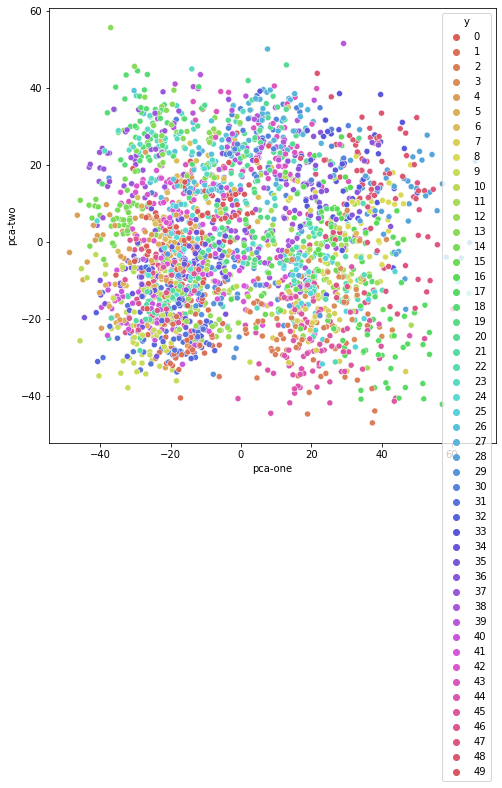

In [27]:
plt.figure(figsize=(8,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 50),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=1.0
)

In [28]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.17198922 0.10899896 0.08923733]


# **T-SNE**

In [29]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.227s...
[t-SNE] Computed neighbors for 2500 samples in 12.463s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 13.843997
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.643574
[t-SNE] KL divergence after 300 iterations: 0.936095
t-SNE done! Time elapsed: 20.21558427810669 seconds


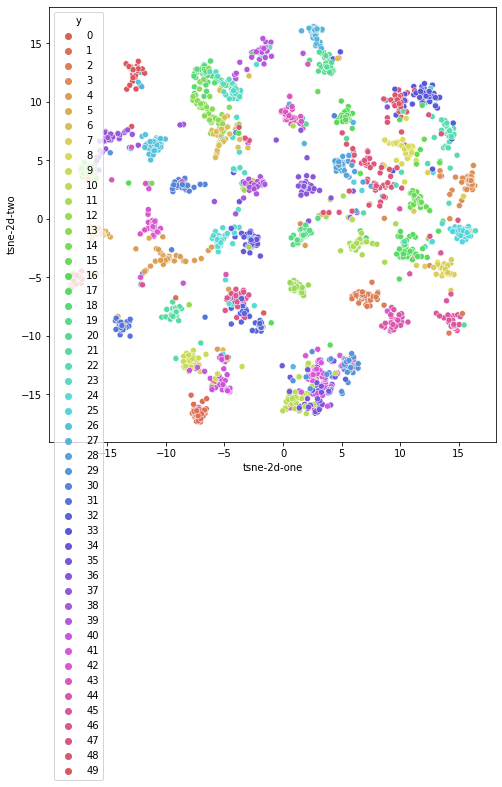

In [30]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 50),
    data=df_subset,
    legend="full",
    alpha=1.0
)

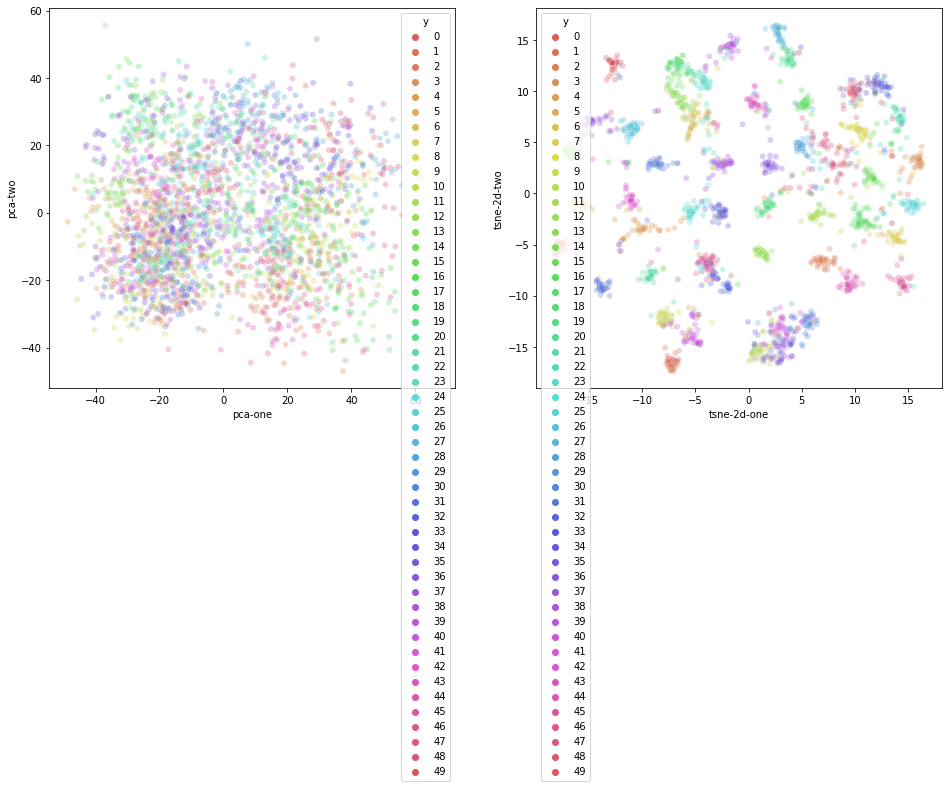

In [31]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 50),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 50),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)